In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
import sys

%matplotlib inline

import matplotlib
# matplotlib.rc('text', usetex=False)  # <-- try this if plots don't work
matplotlib.rc('text', usetex=True) # <-- use this if your matplotlib is set up to play nice with latex

# simulation results

### simulation I

We first create a parameters we can simulate from:

In [450]:
# pick the number of populations and the number of different values that can be returned by each tool
num_ells=20
num_xs=6
num_ys=6

plx_star = np.array([npr.dirichlet(np.ones(num_xs)*npr.exponential()) for x in range(num_ells)])
qxy_star = np.array([npr.dirichlet(np.ones(num_ys)*npr.exponential()) for x in range(num_xs)])
hly_star= plx_star @qxy_star

Let's take a look at what we've made

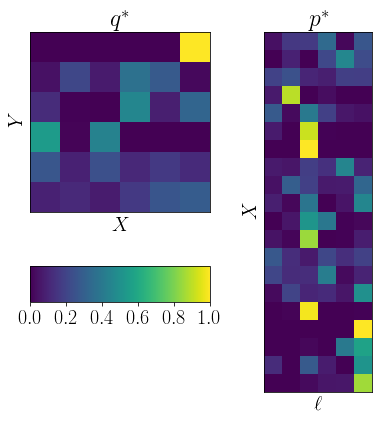

In [548]:
plt.gcf().set_size_inches(5,5)

plt.gcf().add_axes([0,.5,.5,.5])
plt.pcolor(qxy_star,vmin=0,vmax=1)
plt.title("$q^*$"); plt.xticks([]); plt.yticks([])
plt.xlabel("$X$")
plt.ylabel("$Y$")

plt.gcf().add_axes([.65,0,plx_star.shape[1]/plx_star.shape[0],1])
mappable=plt.pcolor(plx_star,vmin=0,vmax=1)
plt.title("$p^*$"); plt.xticks([]); plt.yticks([])
plt.xlabel("$\ell$")
plt.ylabel("$X$")

plt.gcf().add_axes([0,.25,.5,.1])
plt.colorbar(cax=plt.gca(),orientation='horizontal')


plt.savefig('images/simulationIandIIpq.png',dpi=300,bbox_inches='tight')

Now we simulate data:

In [477]:
nsamps=100
Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])

We estimate p,q using the MLM.

In [478]:
ptilde,qtilde = markovlink.point_estimates(Nlx,Nly)
htilde=ptilde@qtilde

Let's see how our estimates stack up to the truth

([], <a list of 0 Text yticklabel objects>)

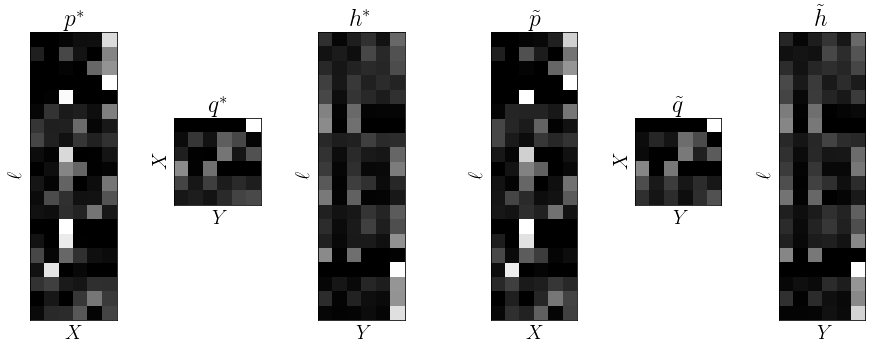

In [479]:
matplotlib.rc('font', size=20)

plt.gcf().set_size_inches(2,2);


prop=.1


plt.gcf().add_axes([0,0,prop*num_xs,prop*num_ells])
plt.pcolor(plx_star[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$X$"); plt.ylabel("$\ell$"); plt.title('$p^*$')
plt.xticks([]); plt.yticks([])

plt.gcf().add_axes([prop*num_xs+.4,prop*num_ells*.4,prop*num_ys,prop*num_xs])
plt.imshow(qxy_star[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$Y$"); plt.ylabel("$X$"); plt.title('$q^*$')
plt.xticks([]); plt.yticks([])

plt.gcf().add_axes([prop*num_xs+prop*num_ys+.8,0,prop*num_ys,prop*num_ells])
plt.imshow(hly_star[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$Y$"); plt.ylabel("$\ell$"); plt.title('$h^*$')
plt.xticks([]); plt.yticks([])


dst=prop*num_xs+prop*num_ys+2.0

plt.gcf().add_axes([dst,0,prop*num_xs,prop*num_ells])
plt.pcolor(ptilde[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$X$"); plt.ylabel("$\ell$"); plt.title('$\\tilde p$')
plt.xticks([]); plt.yticks([])

plt.gcf().add_axes([dst+prop*num_xs+.4,prop*num_ells*.4,prop*num_ys,prop*num_xs])
plt.imshow(qtilde[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$Y$"); plt.ylabel("$X$"); plt.title('$\\tilde q$')
plt.xticks([]); plt.yticks([])

plt.gcf().add_axes([dst+prop*num_xs+prop*num_ys+.8,0,prop*num_ys,prop*num_ells])
foo=plt.imshow(htilde[::-1],vmin=0,vmax=1,cmap='gray'); plt.xlabel("$Y$"); plt.ylabel("$\ell$"); plt.title('$\\tilde h$')
plt.xticks([]); plt.yticks([])


We can see that $q^*$ and $\tilde q$ look fairly similar in basic character.  We can measure their difference quantitatively, through the total variation distance averaged over the rows.  This error measurement ranges from 0 to 1.

In [480]:
markovlink.misc.totalvardist(qtilde,qxy_star)

0.07967747931218554

Not terrible error.

MLM also provides a confidence region.  It is informative to see whether the truth lies in this confidence region.

In [496]:
PPF=markovlink.minorization.estimate_PPF(Nlx,Nly,alpha)
print(PPF,markovlink.minorization.LLR(Nlx,Nly,plx_star,plx_star@qxy_star))

1.0133656876035966 0.8182403582884931


Here the ratio statistic for the truth is less than our `PPF`, so the truth does lie inside the confidence region.

MLM also provides samples from inside a confidence region

In [481]:
# samples from a 90% confidence region
alpha=.10
Ms=markovlink.uncertainty_assessment(Nlx,Nly,alpha,n_extremals=10)

10 samples: 0 1 2 3 4 5 6 7 8 9 

For each `i`, the matrix `Ms[i]` gives a calibration inside a confidence region with approximately a coverage of 1-alpha.  This can be useful way to look at our uncertainty about the true value of the calibration $q$.  Here we will focus on a particular row of $q$, i.e. the vector $q_x = (q(1|x),q(2|x),q(3|x)...)$ for some fixed x.

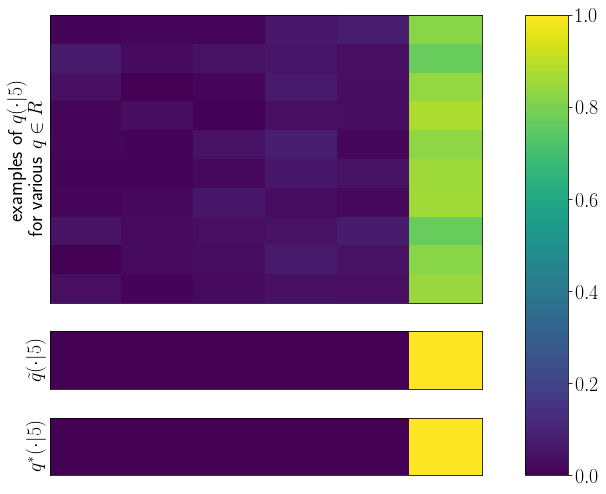

In [482]:
idx=5
mx=qxy_star[idx].max()

plt.gcf().add_axes([0,.6,1,1])
plt.pcolor(Ms[:,idx],vmin=0,vmax=mx); plt.yticks([]); plt.xticks([])
plt.ylabel("examples of $q(\\cdot | %d)$ \\\\ for various $q\in R$"%idx)

plt.gcf().add_axes([0,.3,1.0,.2])
plt.pcolor(qtilde[idx,None],vmin=0,vmax=mx); plt.yticks([]); plt.xticks([])
plt.ylabel("$\\tilde q(\\cdot | %d)$"%idx)

plt.gcf().add_axes([0,0,1.0,.2])
mappable=plt.pcolor(qxy_star[idx,None],vmin=0,vmax=mx); plt.yticks([]); plt.xticks([])
plt.ylabel("$q^*(\\cdot | %d)$"%idx)

plt.gcf().add_axes([1.1,0,.1,1.6])
plt.colorbar(mappable,cax=plt.gca())


How does our accuracy improve as we add more data?

In [495]:
sizes=100*np.exp(np.r_[0:9:50j])

alpha=.05
rez_simI=np.zeros(len(sizes))
rez_simI_nsamps=np.zeros(len(sizes))
for i,nsamps in enumerate(sizes):
    markovlink.misc.pnn(i)
    Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
    Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])
    ptilde,qtilde = markovlink.point_estimates(Nlx,Nly)
    
    rez_simI[i]=markovlink.misc.totalvardist(qtilde,qxy_star)
    rez_simI_nsamps[i]=nsamps*(plx_star.shape[0]+hly_star.shape[0])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

(0, 0.4)

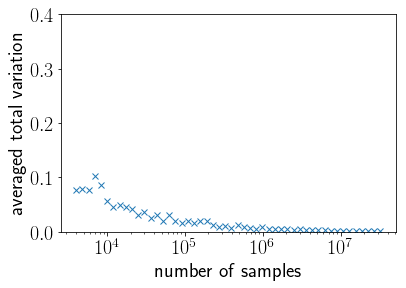

In [524]:
plt.semilogx(rez_simI_nsamps,rez_simI,'x')
plt.xlabel("number of samples")
plt.ylabel("averaged total variation")
plt.ylim(0,.4)

Let's also look at the coverage, for a fixed number of samples.

In [529]:
nsamps=80
covsamps=200
rez_simI_coverage=0
for j in range(covsamps):
    markovlink.misc.pnn(j)
    Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
    Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])
    LLR=markovlink.minorization.LLR(Nlx,Nly,plx_star,plx_star@qxy_star)
    PPF=markovlink.minorization.estimate_PPF(Nlx,Nly,alpha)
    if LLR<PPF:
        rez_simI_coverage+=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [530]:
print(rez_simI_coverage/covsamps)

0.99


In [538]:
nsamps=800
covsamps=200
rez_simI_coverage=0
for j in range(covsamps):
    markovlink.misc.pnn(j)
    Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star])
    Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star])
    LLR=markovlink.minorization.LLR(Nlx,Nly,plx_star,plx_star@qxy_star)
    PPF=markovlink.minorization.estimate_PPF(Nlx,Nly,alpha)
    if LLR<PPF:
        rez_simI_coverage+=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [539]:
print(rez_simI_coverage/covsamps)

0.975


### simulation II

Let's repeat this experiment with fewer subpopulations.  In particular, let's see what would have happened if we took the old subpopulations and merged groups of 4 together:

In [504]:
plx_star_merged = np.mean(plx_star.reshape((num_ells//4,4,num_xs)),axis=0)
hly_star_merged= plx_star_merged @qxy_star

In [505]:
sizes=100*np.exp(np.r_[0:9:50j])//5

rez_simII=np.zeros(len(sizes))
rez_simII_nsamps=np.zeros(len(sizes))
for i,nsamps in enumerate(sizes):
    markovlink.misc.pnn(i)
    Nlx=np.array([npr.multinomial(nsamps*5,x) for x in plx_star_merged])
    Nly=np.array([npr.multinomial(nsamps*5,x) for x in hly_star_merged])
    ptilde,qtilde = markovlink.point_estimates(Nlx,Nly)
    
    
    rez_simII_nsamps[i]=5*nsamps*(plx_star.shape[0]+hly_star.shape[0])
    rez_simII[i]=markovlink.misc.totalvardist(qtilde,qxy_star)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

(0, 0.4)

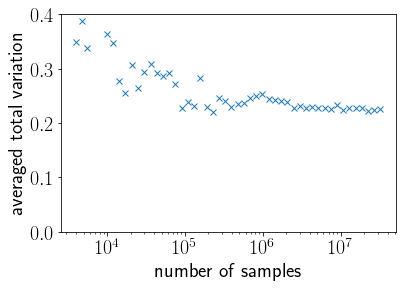

In [525]:
plt.semilogx(rez_simII_nsamps,rez_simII,'x')
plt.xlabel("number of samples")
plt.ylabel("averaged total variation")
plt.ylim(0,.4)

Look at coverage.

In [534]:
nsamps=400
covsamps=200
rez_simII_coverage=0
for j in range(covsamps):
    markovlink.misc.pnn(j)
    Nlx=np.array([npr.multinomial(nsamps,x) for x in plx_star_merged])
    Nly=np.array([npr.multinomial(nsamps,x) for x in hly_star_merged])
    LLR=markovlink.minorization.LLR(Nlx,Nly,plx_star_merged,plx_star_merged@qxy_star)
    PPF=markovlink.minorization.estimate_PPF(Nlx,Nly,alpha)
    if LLR<PPF:
        rez_simII_coverage+=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [537]:
print(rez_simII_coverage/covsamps)

0.965


In [535]:
80*20

1600

In [536]:
400*4

1600

Plot it all together.

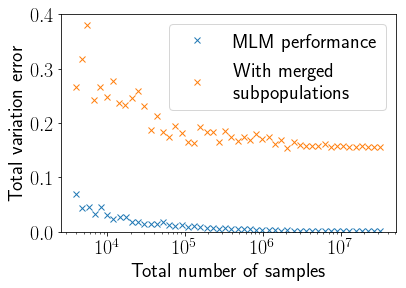

In [493]:
plt.semilogx(rez_simI_nsamps,rez_simI,'x',label='MLM performance')
plt.semilogx(rez_simII_nsamps,rez_simII,'x',label='With merged\n subpopulations')
plt.legend()
plt.xlabel("Total number of samples")
plt.ylabel("Total variation error")
plt.ylim(0,.4)

plt.savefig("images/simulationsIandII.png",dpi=300,bbox_inches='tight')

### simulation III

For our final simulation, we look at how well estimation of $q$ works as a function of the nature of $q$.   We will look at the case that $X,Y$ are independent, the case that $X=Y$, and everything in-between.  We will also look at different numbers of samples.

In [111]:
num_ells=4
num_xs=6
num_ys=num_xs

# we will use the same plx throughout
plx_star = np.array([npr.dirichlet(np.ones(num_xs)*1) for x in range(num_ells)])

# in each sub-experimetn will be a convex combination between AA and BB
AA=np.eye(num_xs)
BB=np.zeros((num_xs,num_xs)); BB[:]=npr.dirichlet(np.ones(num_xs)).reshape((1,-1))

In [543]:
# convexs index the progression from independent to deterministic
convexs=np.r_[0:1:500j][1:-1]

# nsamps are the different number of samples we use
nsamps=[5,50,500,5000]

In [116]:


# we keep track of the error for each q and each number of samples
errs=np.zeros((len(convexs),len(nsamps)))

# iterate through the possible values of q
for i,conv in enumerate(convexs):
    markovlink.misc.pnn(i)
    
    # make the q parameters as a function of conv
    qxy_star = AA*conv+(1-conv)*BB
    hly_star= plx_star @qxy_star
    
    # for each number of samples, simulate a dataset of that size, 
    # estimate q from the dataset, and report the error
    for j,nsamp in enumerate(nsamps):
        Nlx=np.array([npr.multinomial(nsamp,x) for x in plx_star])
        Nly=np.array([npr.multinomial(nsamp,x) for x in hly_star])
        ptilde,qtilde= markovlink.point_estimates(Nlx,Nly,maxtime=120)
        errs[i,j]=markovlink.misc.totalvardist(qtilde,qxy_star)
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

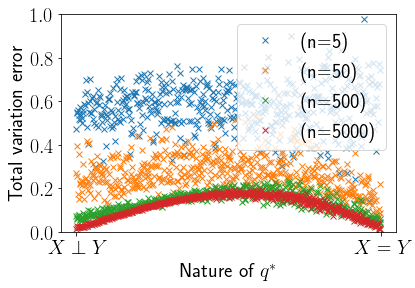

In [546]:
for j,nsamp in enumerate(nsamps):
    plt.plot(convexs,errs[:,j],'x',label='(n=%d)'%nsamp)
plt.ylim(0,1.0)
plt.ylabel("Total variation error")
plt.xticks([0,1],['$X\\perp Y$','$X=Y$'])
plt.xlabel("Nature of $q^*$")
plt.legend()
plt.savefig('images/simulationIII.png',dpi=300,bbox_inches='tight')

# allen institute results

In [549]:
# example input: two matrices, Nly and Nlx
with open('exampletables.pkl','rb') as f:
    locals().update(pickle.load(f))

Our original data comes in the form of two tables.

The first table, `Nlx`, gives the result of running technique I one some data.  This technique takes in a given specimen and returns one of a finite number of different responses, each of which tells us something different about the specimen.  In this case, these responses corresponded to guesses about the cell type of the specimens, which were cells.  In general, any measurement tool that gives one of a discrete number of responses can be used (or, if the response is continuous, we can bin responses to make them discrete).  

To be concrete: `Nlx[l,x]` gives the  the number of samples from subpopulation `l` that that measured as `x` by technique I.  We expect `Nlx` to be a numpy matrix.  

Our input data also has 
- `cre_names`, which gives the name of each subpopulation
- `facs_names`, which gives the name of each possible `x` measurement
- `patch_names`, which gives the name of each possible `y` measurement

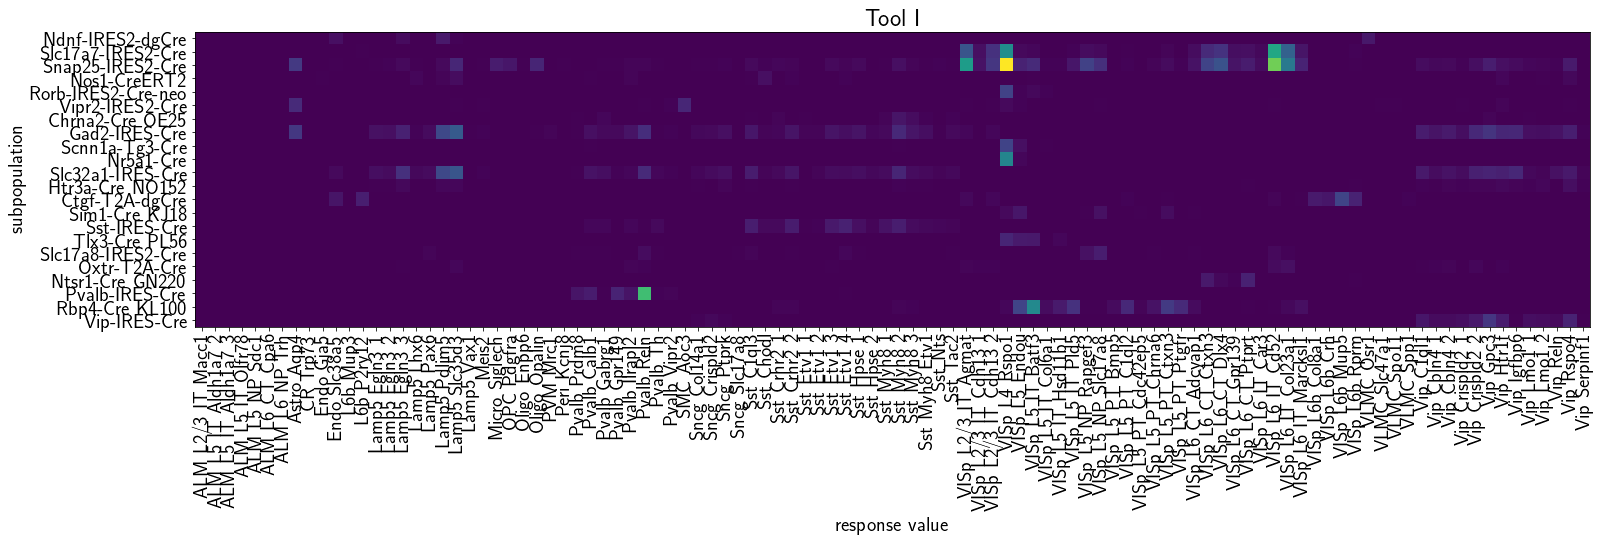

In [133]:
plt.imshow(Nlx); plt.ylabel('subpopulation'); plt.xlabel("response value");
plt.title("Tool I")
plt.gcf().set_size_inches(25,10)
plt.yticks(range(len(cre_names)),[s.replace('_',' ') for s in cre_names])
plt.xticks(range(len(facs_names)),[s.replace('_',' ') for s in facs_names],rotation='vertical');

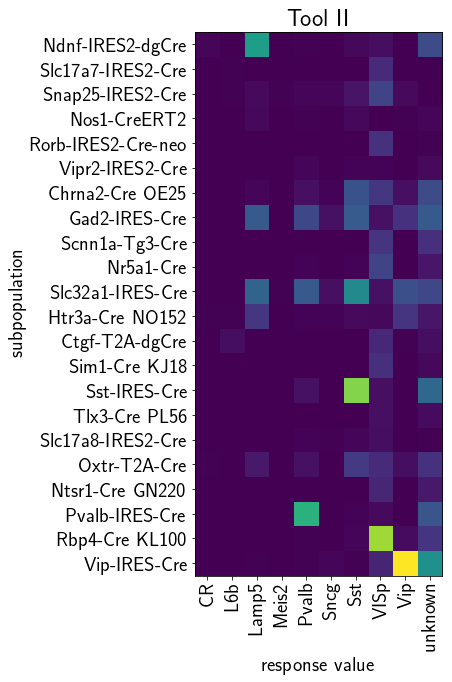

In [135]:
plt.imshow(Nly); 
plt.ylabel('subpopulation'); plt.xlabel("response value"); 
plt.title("Tool II")
plt.gcf().set_size_inches(10,10)
plt.yticks(range(len(cre_names)),[s.replace('_',' ') for s in cre_names])
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical');

In no case was the *same specimen* observed using both techniques.  However, both techniques sampled from the same set of subpopulations.  Using a Markov Link assumption, this enables us to determine a set of possible calibrations, or correspondences between the two methods.

Here we draw a picture showing a close up of some of these tables:

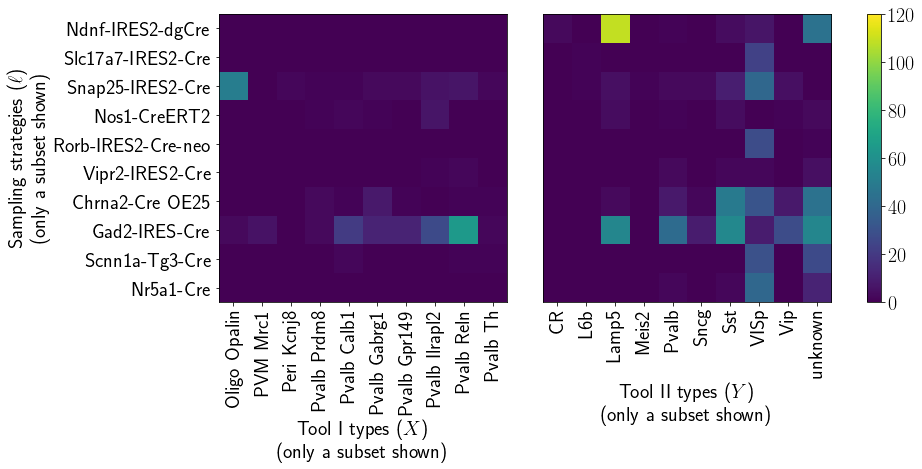

In [569]:
NSUB=np.r_[25:35]
CRESUB=np.r_[:10]
prop=.04
plt.gcf().add_axes([0,0,len(NSUB)*prop,len(CRESUB)*prop])
plt.imshow(Nlx[CRESUB][:,NSUB],vmin=0,vmax=120); 
plt.ylabel('Sampling strategies ($\ell$) \n (only a subset shown)'); plt.xlabel("Response value");
plt.xlabel("Tool I types ($X$) \n (only a subset shown)")
plt.gcf().set_size_inches(25,10)
plt.yticks(range(len(CRESUB)),[s.replace('_',' ') for s in cre_names[CRESUB]])
plt.xticks(range(len(NSUB)),[s.replace('_',' ') for s in facs_names[NSUB]],rotation='vertical')

plt.gcf().add_axes([len(NSUB)*prop+.05,0,Nly.shape[1]*prop,len(CRESUB)*prop])
foo=plt.imshow(Nly[CRESUB],vmin=0,vmax=120); 
plt.gcf().set_size_inches(10,10)
plt.yticks([])
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical');
plt.xlabel("Tool II types ($Y$) \n (only a subset shown)")

plt.gcf().add_axes([len(NSUB)*prop+.05+Nly.shape[1]*prop+.05,0,.02,len(CRESUB)*prop])
plt.colorbar(mappable=foo,cax=plt.gca())

plt.savefig("images/allenNlxy.png",dpi=300,bbox_inches='tight')

### perform hypothesis test to possibly reject the MLM assumption

In [570]:
markovlink.hypothesis_test(Nlx,Nly,alpha=.01)

'fail to reject'

### Look at point estimates and variability

Lets look at a subset of our point estimate for $q$

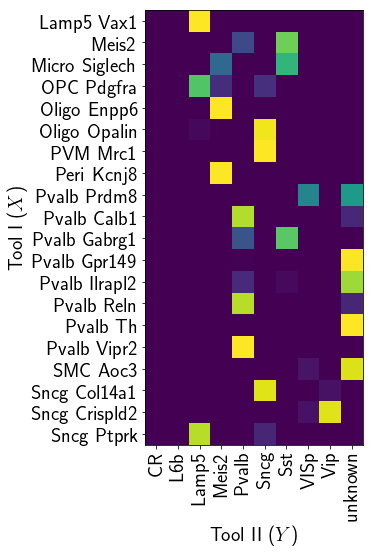

In [561]:
plt.gcf().set_size_inches(4,8)
xsub=slice(20,40)
plt.imshow(qtilde[xsub],vmin=0,vmax=1)
plt.xticks(np.r_[0:len(patch_names)],patch_names,rotation='vertical');
plt.yticks(range(xsub.stop-xsub.start),facs_names[xsub]);
plt.xlabel("Tool II ($Y$)")
plt.ylabel("Tool I ($X$)")
plt.savefig("images/qtilde.png",dpi=300,bbox_inches='tight')

Get samples that help us understand the confidence region.

In [572]:
# here's the code to do it; it is a little slow
# alpha=.05 
# Ms=markovlink.uncertainty_assessment(Nlx,Nly,alpha)
# with open('examplesamples.pkl','wb') as f:
#     pickle.dump(dict(Ms=Ms),f)
    
# we have stored an example here:
with open('examplesamples.pkl','rb') as f:
    locals().update(pickle.load(f))

Examine those samples for a fixed value of $X$.

Pvalb Gpr149


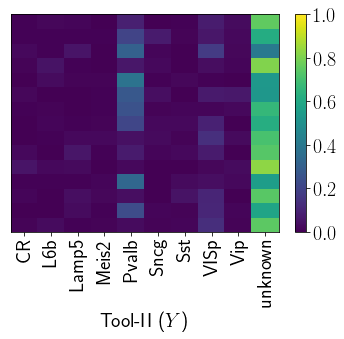

In [446]:
idx=31
print(facs_names[idx])

plt.pcolor(Ms[:15,idx],vmin=0,vmax=1); plt.yticks([]); plt.xticks([])
plt.xlabel("Tool-II ($Y$)")
plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical');
# plt.ylabel("Calibrations inside \n 95\% confidence interval")
# plt.title("Plausible $q_x$")#,rotation=270)
plt.gca().yaxis.set_label_coords(1.02,.5)
ax=plt.gca();
plt.colorbar()

plt.savefig("images/vviz1A.png",dpi=300,bbox_inches='tight')

We'll make a collection of such plots

In [590]:
facs_names[[13,18,33,58,51,93,95,96,102]]

array(['Lamp5 Egln3_1', 'Lamp5 Pdlim5', 'Pvalb Reln',
       'VISp L2/3 IT Cdh13_1', 'Sst Myh8_1', 'Vip Cbln4_2',
       'Vip Crispld2_2', 'Vip Gpc3', 'Vip Rspo4'], dtype=object)

In [591]:
[13,18,33,58,51,93,95,96,102][7]

96

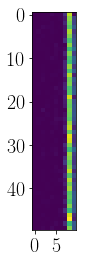

In [593]:
plt.imshow(Ms[:,96])

In [624]:
np.where(Nlx[:,13]>10)[0]

array([ 7, 10])

In [626]:
facs_names[13]

'Lamp5 Egln3_1'

In [628]:
Nlx[7,13]

22.0

In [629]:
Nly[7]

array([ 0.,  0., 55.,  0., 42.,  9., 56.,  9., 28., 55.])

In [597]:
np.where(Nlx[:,96]>40)

(array([ 7, 10, 21]),)

In [612]:
Nlx[7,96]

74.0

In [625]:
cre_names[7],cre_names[10]

('Gad2-IRES-Cre', 'Slc32a1-IRES-Cre')

In [615]:

matplotlib.rc('text', usetex=False)  # <-- try this if plots don't work

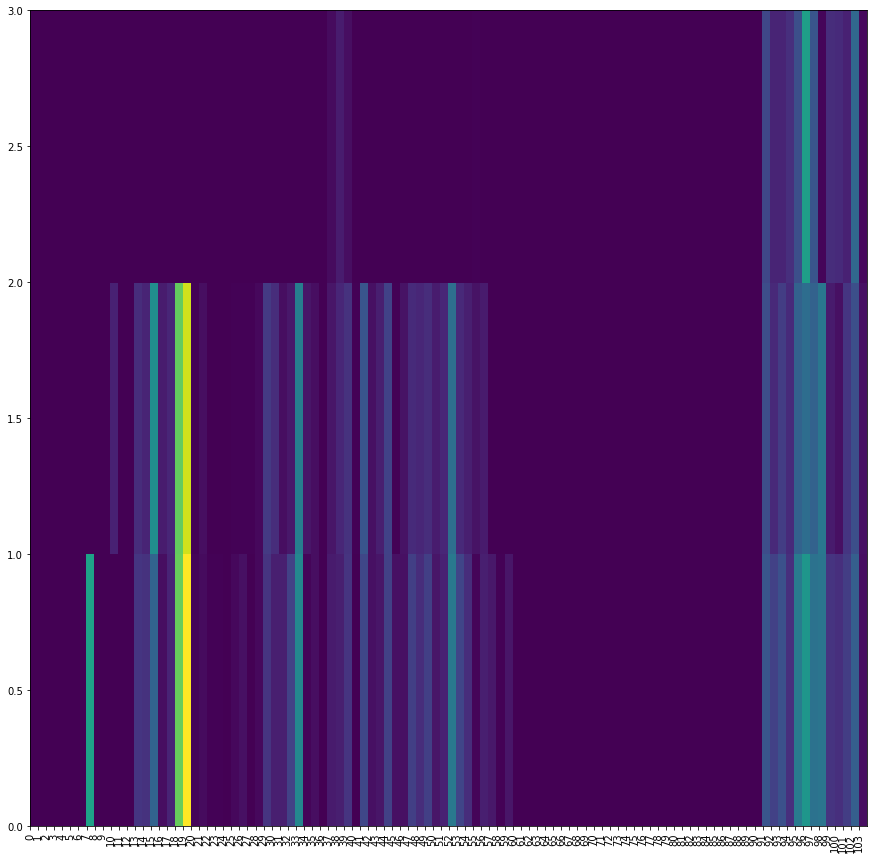

In [620]:
plt.gcf().set_size_inches(15,15)
plt.pcolor(Nlx[[7,10,21]])

# matplotlib.rc('font', size=20)
matplotlib.rc('font', size=10)

plt.xticks(np.r_[0:104],rotation='vertical');#,[x.replace("_"," ") for x in facs_names],rotation='vertical');

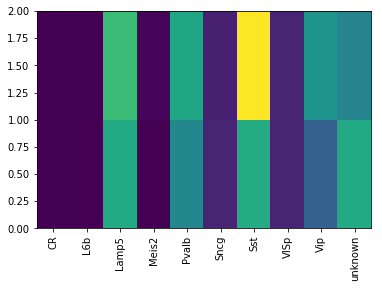

In [632]:
plt.pcolor(Nly[[7,10]])
plt.xticks(np.r_[0:10]+.5,patch_names,rotation='vertical');

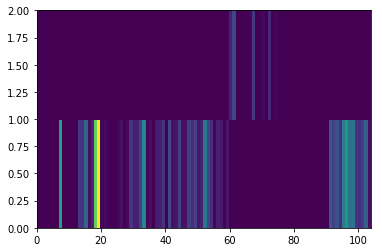

In [631]:
plt.pcolor(Nlx[[7,13]])

In [ ]:
Nlx[7,]

In [599]:
facs_names[96]

'Vip Gpc3'

In [600]:
cre_names

array(['Ndnf-IRES2-dgCre', 'Slc17a7-IRES2-Cre', 'Snap25-IRES2-Cre',
       'Nos1-CreERT2', 'Rorb-IRES2-Cre-neo', 'Vipr2-IRES2-Cre',
       'Chrna2-Cre_OE25', 'Gad2-IRES-Cre', 'Scnn1a-Tg3-Cre', 'Nr5a1-Cre',
       'Slc32a1-IRES-Cre', 'Htr3a-Cre_NO152', 'Ctgf-T2A-dgCre',
       'Sim1-Cre_KJ18', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56',
       'Slc17a8-IRES2-Cre', 'Oxtr-T2A-Cre', 'Ntsr1-Cre_GN220',
       'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Vip-IRES-Cre'], dtype='<U32')

In [595]:
Ms[-1,96].min()

0.0002676766212940941

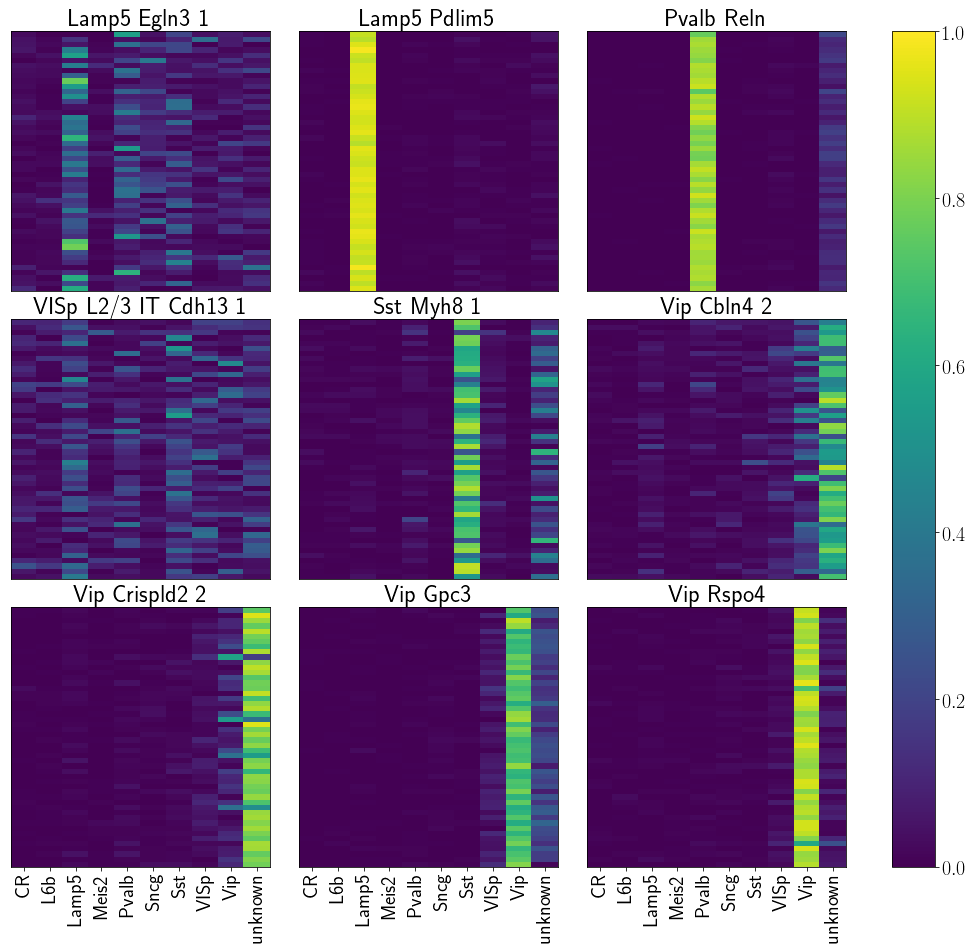

In [588]:
guys=[13,18,33,58,51,93,95,96,102]

plt.gcf().set_size_inches(12,12)

for i in range(9):
    row=i//3
    col=i%3
    
    plt.gcf().add_axes([col/3,2/3.0-row/3,.3,.3])
    mappable=plt.pcolor(Ms[:,guys[i]],vmin=0,vmax=1); 
    plt.yticks([]); plt.xticks([])
    plt.title(facs_names[guys[i]].replace("_"," "))
    
    if row==2:
        plt.xticks(np.r_[0:len(patch_names)]+.5,patch_names,rotation='vertical');
        

plt.gcf().add_axes([1.02,0.0,.05,2/3.0+.3])
plt.colorbar(cax=plt.gca())

plt.savefig("images/vviz.png",dpi=300,bbox_inches='tight')

0.9666666666666666

In [210]:
facs_names

array(['ALM L2/3 IT Macc1', 'ALM L5 IT Aldh1a7_2', 'ALM L5 IT Aldh1a7_3',
       'ALM L5 IT Olfr78', 'ALM L5 NP Sdc1', 'ALM L6 CT Cpa6',
       'ALM L6 NP Trh', 'Astro Aqp4', 'CR Trp73', 'Endo Gja5',
       'Endo Slc38a5', 'L6b Mup3', 'L6b P2ry12', 'Lamp5 Egln3_1',
       'Lamp5 Egln3_2', 'Lamp5 Egln3_3', 'Lamp5 Lhx6', 'Lamp5 Pax6',
       'Lamp5 Pdlim5', 'Lamp5 Slc35d3', 'Lamp5 Vax1', 'Meis2',
       'Micro Siglech', 'OPC Pdgfra', 'Oligo Enpp6', 'Oligo Opalin',
       'PVM Mrc1', 'Peri Kcnj8', 'Pvalb  Prdm8', 'Pvalb Calb1',
       'Pvalb Gabrg1', 'Pvalb Gpr149', 'Pvalb Ilrapl2', 'Pvalb Reln',
       'Pvalb Th', 'Pvalb Vipr2', 'SMC Aoc3', 'Sncg Col14a1',
       'Sncg Crispld2', 'Sncg Ptprk', 'Sncg Slc17a8', 'Sst C1ql3',
       'Sst Chodl', 'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Etv1_1',
       'Sst Etv1_2', 'Sst Etv1_3', 'Sst Etv1_4', 'Sst Hpse_1',
       'Sst Hpse_2', 'Sst Myh8_1', 'Sst Myh8_2', 'Sst Myh8_3',
       'Sst Myh8_Etv1', 'Sst Nts', 'Sst Tac2', 'VISp L2/3 IT Agmat',
       'VIS